In [ ]:
!pip install matplotlib image_classifiers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, UpSampling2D, Dropout, BatchNormalization, RandomFlip, RandomTranslation, RandomRotation,RandomBrightness, RandomContrast, RandomZoom, GlobalAveragePooling2D, Conv2D, MaxPooling2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from classification_models.keras import Classifiers

Using TensorFlow backend


In [ ]:
n_epoch = 1000 # Il y a le early stopping
batch_size = 100
taux_validation = 0.1
num_classes = 100
n_images = 50000 # Pour l'entrainement, et 10000 pour le test

In [ ]:
!mc cp s3/afeldmann/modele_enseignant.keras /home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_enseignant.keras
modele_enseignant = tf.keras.models.load_model("~/modele_enseignant.keras")

In [ ]:
def preprocessing(image, label):
    image = tf.image.resize(image, (224, 224))
    label = tf.squeeze(tf.one_hot(label, depth = num_classes), axis = 0)
    return  image, label

augmentation_donnees_keras = Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(0.2,0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2,value_range=(0,1))
])

def augmentation_donnees(image, label):
    return augmentation_donnees_keras(image/255.0, training = True)*255.0, label

def preprocess_resnet(image, label):
    return preprocess_input(image), label

train_dataset, test_dataset = cifar100.load_data()

validation_size = int(n_images * taux_validation)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).map(preprocessing).shuffle(n_images, reshuffle_each_iteration=False)
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset).map(preprocessing)

validation_dataset = train_dataset.take(validation_size).cache().batch(batch_size).map(preprocess_resnet).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.skip(validation_size).cache().batch(batch_size).map(augmentation_donnees,num_parallel_calls=tf.data.AUTOTUNE).map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
resnet = ResNet18()

resnet.summary()

In [ ]:
def ResNet18():
    resnet18, preprocess_input = Classifiers.get('resnet18')
    resnet = resnet18((224, 224, 3), weights='imagenet', include_top=False)
    resnet_output = GlobalAveragePooling2D()(resnet.output)
    resnet = Model(inputs=resnet.input, outputs=resnet_output)
    return resnet

modele_eleve_1 = Sequential([
    ResNet18(),
    Dropout(0.25),
    Dense(256, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.L1(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.001))
])

In [ ]:
modele_eleve_1.compile(optimizer='adam', loss='kl_divergence', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, start_from_epoch=20)
csv_logger = CSVLogger("sauvegardes/modele_eleve_1_logs.csv", separator=",", append=True)
model_checkpoint_callback = ModelCheckpoint(filepath="sauvegardes/modele_eleve_1_checkpoint.keras", monitor='val_loss', save_best_only=True)
modele_eleve_1.fit(train_dataset, epochs=n_epoch, batch_size=batch_size, validation_data = validation_dataset, callbacks = [early_stopping_callback, csv_logger, model_checkpoint_callback])

Epoch 1/1000
113/113 [==============================] - 62s 357ms/step - loss: 5.9655 - accuracy: 0.1462 - val_loss: 4.9032 - val_accuracy: 0.0120
Epoch 2/1000
113/113 [==============================] - 29s 259ms/step - loss: 3.2051 - accuracy: 0.2749 - val_loss: 5.4197 - val_accuracy: 0.0138
Epoch 3/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.7921 - accuracy: 0.3590 - val_loss: 5.1615 - val_accuracy: 0.0138
Epoch 4/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.5426 - accuracy: 0.4259 - val_loss: 5.9302 - val_accuracy: 0.0174
Epoch 5/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.3676 - accuracy: 0.4724 - val_loss: 4.7883 - val_accuracy: 0.0764
Epoch 6/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.2358 - accuracy: 0.5054 - val_loss: 4.8004 - val_accuracy: 0.1006
Epoch 7/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.1200 - accuracy: 0.5338 - val_loss: 3

In [ ]:
modele_eleve_1.save("sauvegardes/modele_eleve_1.keras")

In [ ]:
modele_eleve_1.evaluate(test_dataset)

313/313 [==============================] - 3s 8ms/step - loss: 1.7106 - accuracy: 0.6926


[1.7105575799942017, 0.6926000118255615]

In [ ]:
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_eleve_1.keras s3/afeldmann/modele_eleve_1.keras

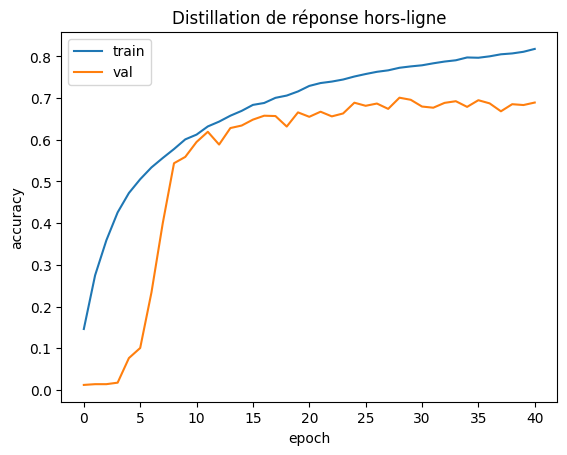

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'][:])
plt.plot(history.history['val_accuracy'][:])
plt.title('Distillation de réponse hors-ligne')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
resnet = ResNet18()

modele_temoin_1 = Sequential([
    ResNet18(),
    Dropout(0.25),
    Dense(256, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.L1(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.001))
])

In [ ]:
modele_temoin_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, start_from_epoch=20)
csv_logger = CSVLogger("sauvegardes/modele_temoin_1_logs.csv", separator=",", append=True)
model_checkpoint_callback = ModelCheckpoint(filepath="sauvegardes/modele_temoin_1_checkpoint.keras", monitor='val_loss', save_best_only=True)
modele_temoin_1.fit(train_dataset, epochs=n_epoch, batch_size=batch_size, validation_data = validation_dataset, callbacks = [early_stopping_callback, csv_logger, model_checkpoint_callback])

Epoch 1/1000
113/113 [==============================] - 40s 266ms/step - loss: 6.6940 - accuracy: 0.1256 - val_loss: 6.1290 - val_accuracy: 0.0060
Epoch 2/1000
113/113 [==============================] - 29s 259ms/step - loss: 3.8506 - accuracy: 0.2502 - val_loss: 5.7719 - val_accuracy: 0.0088
Epoch 3/1000
113/113 [==============================] - 29s 259ms/step - loss: 3.4178 - accuracy: 0.3245 - val_loss: 6.2616 - val_accuracy: 0.0098
Epoch 4/1000
113/113 [==============================] - 29s 259ms/step - loss: 3.1687 - accuracy: 0.3831 - val_loss: 5.5017 - val_accuracy: 0.0452
Epoch 5/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.9707 - accuracy: 0.4344 - val_loss: 5.8856 - val_accuracy: 0.0480
Epoch 6/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.8198 - accuracy: 0.4712 - val_loss: 5.0910 - val_accuracy: 0.1194
Epoch 7/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.6866 - accuracy: 0.5066 - val_loss: 4

In [ ]:
modele_temoin_1.save("sauvegardes/modele_temoin_1.keras")

In [ ]:
modele_temoin_1.evaluate(test_dataset)

313/313 [==============================] - 2s 7ms/step - loss: 1.9605 - accuracy: 0.6699


[1.9604902267456055, 0.6699000000953674]

In [ ]:
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_temoin_1.keras s3/afeldmann/modele_temoin_1.keras

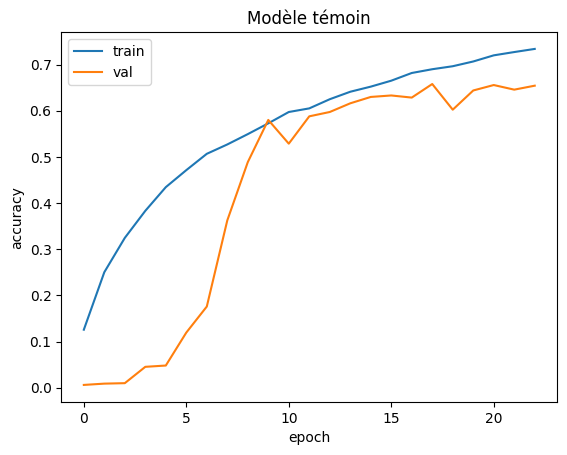

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'][:])
plt.plot(history.history['val_accuracy'][:])
plt.title('Modèle témoin')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
modele_eleve_2 = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation="sigmoid"),
    Dense(num_classes, activation="softmax")
])

In [ ]:
modele_eleve_2.compile(optimizer='adam', loss='kl_divergence', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, start_from_epoch=20)
csv_logger = CSVLogger("sauvegardes/modele_eleve_2_logs.csv", separator=",", append=True)
model_checkpoint_callback = ModelCheckpoint(filepath="sauvegardes/modele_eleve_2_checkpoint.keras", monitor='val_loss', save_best_only=True)
modele_eleve_2.fit(train_dataset, epochs=n_epoch, batch_size=batch_size, validation_data = validation_dataset, callbacks = [early_stopping_callback, csv_logger, model_checkpoint_callback])

Epoch 1/1000
352/352 [==============================] - 11s 24ms/step - loss: 3.5028 - accuracy: 0.0831 - val_loss: 2.9349 - val_accuracy: 0.1446
Epoch 2/1000
352/352 [==============================] - 8s 23ms/step - loss: 3.1474 - accuracy: 0.1348 - val_loss: 2.7105 - val_accuracy: 0.1898
Epoch 3/1000
352/352 [==============================] - 8s 23ms/step - loss: 2.9885 - accuracy: 0.1638 - val_loss: 2.5417 - val_accuracy: 0.2228
Epoch 4/1000
352/352 [==============================] - 8s 23ms/step - loss: 2.8768 - accuracy: 0.1841 - val_loss: 2.4617 - val_accuracy: 0.2392
Epoch 5/1000
352/352 [==============================] - 8s 23ms/step - loss: 2.7853 - accuracy: 0.1976 - val_loss: 2.4211 - val_accuracy: 0.2388
Epoch 6/1000
352/352 [==============================] - 8s 23ms/step - loss: 2.7012 - accuracy: 0.2189 - val_loss: 2.2627 - val_accuracy: 0.2776
Epoch 7/1000
352/352 [==============================] - 8s 23ms/step - loss: 2.6301 - accuracy: 0.2327 - val_loss: 2.2394 - val_a

In [ ]:
modele_eleve_2.save("sauvegardes/modele_eleve_2.keras")

In [ ]:
modele_eleve_2.evaluate(test_dataset)

In [ ]:
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_eleve_2.keras s3/afeldmann/modele_eleve_2.keras

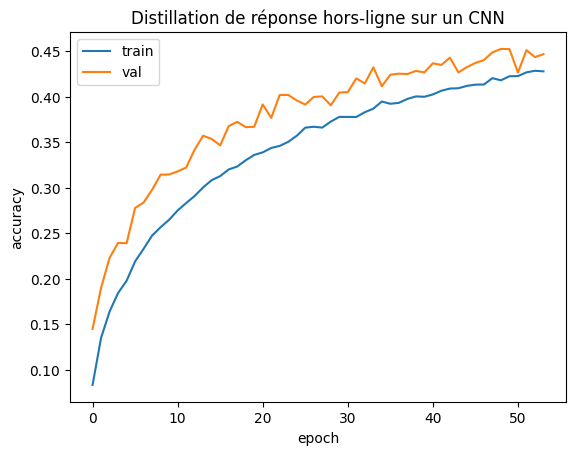

1563/1563 [==============================] - 5s 3ms/step - loss: 1.8936 - accuracy: 0.4982


[1.8935940265655518, 0.498199999332428]

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'][:])
plt.plot(history.history['val_accuracy'][:])
plt.title('Distillation de réponse hors-ligne sur un CNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
modele_temoin_2 = tf.keras.models.Sequential([
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation="sigmoid"),
    Dense(num_classes, activation="softmax")
])

Epoch 1/1000
352/352 [==============================] - 11s 24ms/step - loss: 4.1646 - accuracy: 0.0599 - val_loss: 3.7630 - val_accuracy: 0.1202
Epoch 2/1000
352/352 [==============================] - 8s 23ms/step - loss: 3.7547 - accuracy: 0.1185 - val_loss: 3.4463 - val_accuracy: 0.1876
Epoch 3/1000
352/352 [==============================] - 8s 23ms/step - loss: 3.5792 - accuracy: 0.1495 - val_loss: 3.3004 - val_accuracy: 0.2008
Epoch 4/1000
352/352 [==============================] - 8s 23ms/step - loss: 3.4624 - accuracy: 0.1675 - val_loss: 3.2048 - val_accuracy: 0.2216
Epoch 5/1000
352/352 [==============================] - 8s 23ms/step - loss: 3.3669 - accuracy: 0.1844 - val_loss: 3.1242 - val_accuracy: 0.2350
Epoch 6/1000
352/352 [==============================] - 8s 23ms/step - loss: 3.2737 - accuracy: 0.2037 - val_loss: 3.0284 - val_accuracy: 0.2566
Epoch 7/1000
352/352 [==============================] - 8s 23ms/step - loss: 3.2022 - accuracy: 0.2168 - val_loss: 2.9833 - val_a

In [ ]:
modele_temoin_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, start_from_epoch=20)
csv_logger = CSVLogger("sauvegardes/modele_temoin_2_logs.csv", separator=",", append=True)
model_checkpoint_callback = ModelCheckpoint(filepath="sauvegardes/modele_temoin_2_checkpoint.keras", monitor='val_loss', save_best_only=True)
modele_temoin_2.fit(train_dataset, epochs=n_epoch, batch_size=batch_size, validation_data = validation_dataset, callbacks = [early_stopping_callback, csv_logger, model_checkpoint_callback])

In [ ]:
modele_temoin_2.save("sauvegardes/modele_temoin_2.keras")

In [ ]:
modele_temoin_2.evaluate(test_dataset)

In [ ]:
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_temoin_2.keras s3/afeldmann/modele_temoin_2.keras

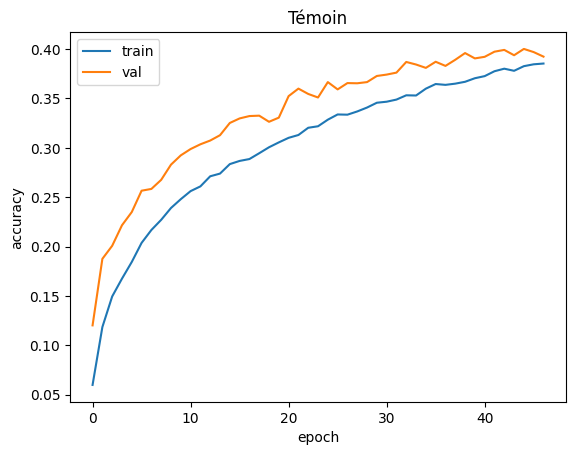

1563/1563 [==============================] - 5s 3ms/step - loss: 1.9817 - accuracy: 0.4690


[1.981721043586731, 0.4689599871635437]

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'][:])
plt.plot(history.history['val_accuracy'][:])
plt.title('Témoin')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()